In [ ]:
#Imports
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def unet(input_size=(224,224,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:

UNETmodel = unet(input_size=(224,224,1))
UNETmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
UNETmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="/content/drive/MyDrive/KLS_weights.best (1).hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

UNETmodel.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
UNETmodel.load_weights('/content/drive/MyDrive/KLS_weights.best (1).hdf5')

# Load Data

In [ ]:
val_image_path = os.path.join("/content/drive/MyDrive/chest_x_ray_images_012/images")
val_images = os.listdir(val_image_path)

In [ ]:
val_labels = open('/content/drive/MyDrive/test_rad_consensus_voted3.txt')
val_labels = val_labels.readlines()

In [ ]:
X_val = []
y_val = []

for x in range(len(val_labels)):
  if val_labels[x].split(' ')[0] in val_images:
    image_path = val_labels[x].split(' ')[0]
    label = int(val_labels[x].split(' ')[1][0])

    im_1 = cv2.resize(cv2.imread(os.path.join(val_image_path, image_path)),(224, 224))[:,:,0]
    im_1.astype(np.float32) / 255.0

    X_val.append(im_1)
    y_val.append(label)

In [ ]:
dim = 224

In [ ]:
X_val = np.array(X_val).reshape(len(X_val),dim,dim,1)

In [ ]:
X_val.shape

(459, 224, 224, 1)

# Run Classification model on validation data

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class DataGenerator(Dataset):

	def __init__(self, img_dir, split_file, transform):

		self.img_name_list = []
		self.img_label_list = []
		self.transform = transform
		self.img_directory = img_dir

		with open(split_file, 'r') as split_name:
			img_and_label_list = split_name.readlines()

		for index in img_and_label_list:
			img_path = os.path.join(img_dir, index.split()[0])
			# img_label = [int(index.split()[1])]
			img_label = int(index.split()[1][0])


			if index.split()[0] in os.listdir(self.img_directory):
				self.img_name_list.append(img_path)
				self.img_label_list.append(img_label)

	def __getitem__(self, index):

		img_name = self.img_name_list[index]
		img_path = os.path.join(self.img_directory, img_name)
		image_data = Image.open(img_path).convert('RGB')
		image_data = self.transform(image_data)
		# image_label= torch.FloatTensor(self.img_label_list[index])
		image_label= self.img_label_list[index]

		return (image_data, image_label, img_name)

	def __len__(self):

		return len(self.img_name_list)

In [ ]:
from __future__ import print_function
from __future__ import division
import os
import argparse
import distutils.util
import numpy as np
import sys
import torch
import torch.nn as nn
from torchvision import models, transforms
# from sklearn.metrics import roc_auc_score
# from PIL import Image
# import time

import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
import time
import copy
# from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import metrics

parser = argparse.ArgumentParser(description='PyTorch NIH-CXR Testing')

parser.add_argument('--arch', '-a', metavar='ARCH', default='densenet121')
parser.add_argument('--img_size', '-sz', default=256, type=int)
parser.add_argument('--crop_size', '-cs', default=224, type=int)
parser.add_argument('--epoch', '-ep', default=50, type=int)
parser.add_argument('--batch_size', '-bs', default=16, type=int)
parser.add_argument('--learning_rate', '-lr', default=0.001, type=float)
parser.add_argument('--gpu_id', '-gpu', default=0, type=int)
#parser.add_argument('--test_labels', default='att', type=str) #default: '': attending radiologist labels. 'con' for radiologist consensus.
parser.add_argument('-f')


def run_test():
	global args
	args = parser.parse_args()

	model = models.__dict__[args.arch](pretrained=True)

	torch.cuda.set_device(args.gpu_id)

	# number of classes
	numClass = 1

	# image folder location
	img_dir = "/content/drive/MyDrive/chest_x_ray_images_012/images"

	# dataset split files
	split_file_dir = './dataset_split'
	split_name = 'test'
	splits = [split_name]

	#if args.test_labels == 'att':
#		split_file_suffix = '_attending_rad.txt'
	#elif args.test_labels == 'con':
	#	split_file_suffix = '_rad_consensus_voted3.txt'
#
#	split_files = {}
#	for split in splits:
#		split_files[split] = os.path.join(split_file_dir,
#			split+split_file_suffix)



	# modify the last FC layer to number of classes
	num_ftrs = model.classifier.in_features
	model.classifier = nn.Linear(num_ftrs, numClass)

	model = model.cuda()

	model_path = '/content/drive/MyDrive/densenet121_256_64_0.001'

	model.load_state_dict(torch.load(model_path)['state_dict'])

	print("Model successfully loaded!")

	test(img_dir, '/content/drive/MyDrive/test_rad_consensus_voted3.txt', split_name, model, batch_size=args.batch_size, \
		img_size=args.img_size, crop_size=args.crop_size, gpu_id=args.gpu_id)


def test(img_dir, split_test, split_name, model, batch_size, img_size, crop_size, gpu_id):

	# -------------------- SETTINGS: CXR DATA TRANSFORMS -------------------
	normalizer = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
	data_transforms = {split_name: transforms.Compose([
		transforms.Resize(img_size),
		# transforms.RandomResizedCrop(crop_size),
		transforms.CenterCrop(crop_size),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])}

	# -------------------- SETTINGS: DATASET BUILDERS -------------------
	datasetTest = DataGenerator(img_dir=img_dir, split_file=split_test,
								transform=data_transforms[split_name])

	dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=batch_size,
								shuffle=False, num_workers=2, pin_memory=True)

	print('Data successfully generated!')
	dataloaders = {}
	dataloaders[split_name] = dataLoaderTest

	print('Number of testing CXR images: {}'.format(len(datasetTest)))
	dataset_sizes = {split_name: len(datasetTest)}

	print("Model evaluating...")
	# -------------------- TESTING -------------------
	model.eval()
	running_corrects = 0
	output_list = []
	label_list = []
	preds_list = []

	print("Model set to evaluation mode...")
	with torch.no_grad():
		# Iterate over data.
		print("Model about to gather data...")
		for data in dataloaders[split_name]:
			print("Model gathering data...")
			inputs, labels, img_names = data

			print("Data gathered.")
			labels_auc = labels
			labels_print = labels
			labels_auc = labels_auc.type(torch.FloatTensor)
			labels = labels.type(torch.LongTensor) #add for BCE loss

			# wrap them in Variable
			inputs = inputs.cuda(gpu_id, non_blocking=True)
			labels = labels.cuda(gpu_id, non_blocking=True)
			labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

			labels = labels.view(labels.size()[0],-1) #add for BCE loss
			labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
			# forward
			print("Generating predictions...")
			outputs = model(inputs)
			# _, preds = torch.max(outputs.data, 1)
			score = torch.sigmoid(outputs)
			score_np = score.data.cpu().numpy()
			preds = score>0.8
			preds_np = preds.data.cpu().numpy()
			preds = preds.type(torch.cuda.LongTensor)

			labels_auc = labels_auc.data.cpu().numpy()
			outputs = outputs.data.cpu().numpy()

			for j in range(len(img_names)):
				print(str(img_names[j]) + ': ' + str(score_np[j]) + ' GT: ' + str(labels_print[j]))

			for i in range(outputs.shape[0]):
				output_list.append(outputs[i].tolist())
				label_list.append(labels_auc[i].tolist())
				preds_list.append(preds_np[i].tolist())

			# running_corrects += torch.sum(preds == labels.data)
			# labels = labels.type(torch.cuda.FloatTensor)
			running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss

	acc = np.float(running_corrects) / dataset_sizes[split_name]
	auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
	# print(auc)
	fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
	roc_auc = metrics.auc(fpr, tpr)

	ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

	tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

	recall = tp/(tp+fn)
	precision = tp/(tp+fp)
	f1 = 2*precision*recall/(precision+recall)
	sensitivity = recall
	specificity = tn/(tn+fp)
	PPV = tp/(tp+fp)
	NPV = tn/(tn+fn)
	print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
	print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
	print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
	print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
	print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
	# Plot all ROC curves
	plt.figure()
	plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.0])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC curve of abnormal/normal classification: '+args.arch)
	plt.legend(loc="lower right")
	#plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
	plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s]


Model successfully loaded!
Data successfully generated!
Number of testing CXR images: 459
Model evaluating...
Model set to evaluation mode...
Model about to gather data...
Model gathering data...
Data gathered.
Generating predictions...
/content/drive/MyDrive/chest_x_ray_images_012/images/00030408_011.png: [0.950481] GT: tensor(1)
/content/drive/MyDrive/chest_x_ray_images_012/images/00030791_000.png: [0.02405442] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029637_000.png: [0.723842] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029811_000.png: [0.15933758] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00030110_000.png: [0.15869553] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029534_000.png: [0.08911594] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00028602_000.png: [0.06172322] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029733_000.png: [0.1582835

<ipython-input-5-f8ed70a02e31>:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = np.float(running_corrects) / dataset_sizes[split_name]


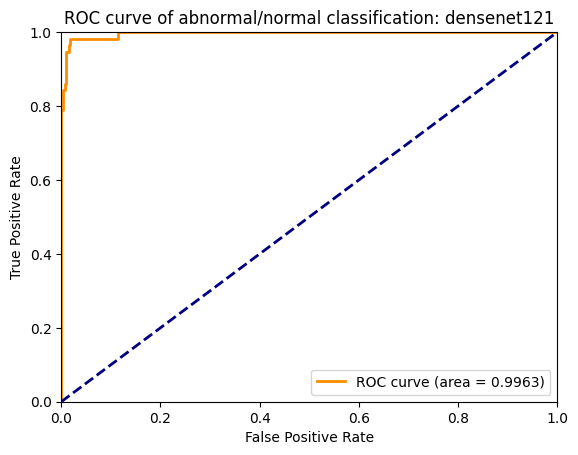

In [ ]:
run_test()

# Create ROIs

In [ ]:
preds = UNETmodel.predict(X_val)

15/15 [==============================] - 18s 236ms/step


In [ ]:
def create_apply_ROI(original_image, mask):
  max_x = 0
  min_x = len(mask)
  max_y = 0
  min_y = len(mask)
  ROI_image = []

  for x in range(len(mask)):
    for y in range(len(mask)):
      if mask[y][x] == 1:
        if x < min_x:
          min_x = x
        if x > max_x:
          max_x = x
        if y < min_y:
          min_y = y
        if y > max_y:
          max_y = y

  for x in range(len(mask)):
    padding = 0.05*(len(mask))
    y_list = []
    if x > min_x-padding and x < max_x+padding:
      for y in range(len(mask)):
        if y > min_y-padding and y < max_y+padding:
          y_list.append(original_image[y][x])
      ROI_image.append(y_list)
  ROI_image = np.array(ROI_image)
  ROI_image = cv2.resize(ROI_image, (256, 256))
  ROI_image = cv2.rotate(ROI_image, cv2.ROTATE_90_CLOCKWISE)
  ROI_image = cv2.flip(ROI_image, 1)

  return ROI_image

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class ROIDataGenerator(Dataset):

	def __init__(self, img_dir, split_file, transform):

		self.img_name_list = []
		self.img_label_list = []
		self.transform = transform
		self.img_directory = img_dir

		with open(split_file, 'r') as split_name:
			img_and_label_list = split_name.readlines()

		for index in img_and_label_list:
			img_path = os.path.join(img_dir, index.split()[0])
			# img_label = [int(index.split()[1])]
			img_label = int(index.split()[1][0])


			if index.split()[0] in os.listdir(self.img_directory):
				self.img_name_list.append(img_path)
				self.img_label_list.append(img_label)

	def __getitem__(self, index):

    #Get image name and path
		img_name = self.img_name_list[index]
		img_path = os.path.join(self.img_directory, img_name)
    #Convert image path into the image
		image_data = Image.open(img_path).convert('RGB')
    #Get the image classification
		image_label= self.img_label_list[index]

    #Turn the image into a numpy array
		np_image_data = np.array(image_data)
    #Get a black and white version of the image and create a segmentation
		UNET_seg = preds[index]
    #Put the numpy image and the segmentation and create an ROI
		ROI_image_data = create_apply_ROI(cv2.resize(np_image_data, (256,256)), cv2.resize(UNET_seg,(256, 256)))

    #Turn the ROI extracted image back into a PIL image
		PIL_ROI_image_data = Image.fromarray(ROI_image_data)

		final_image_data = self.transform(PIL_ROI_image_data)
    #Return the results
		return (final_image_data, image_label, img_name)
	def __len__(self):

		return len(self.img_name_list)

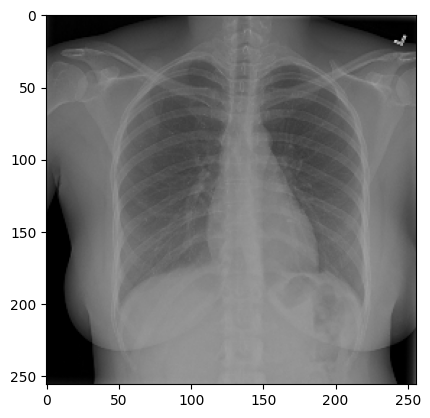

In [ ]:
img_path = '/content/drive/MyDrive/chest_x_ray_images_012/images/00028602_000.png'
image_data = Image.open(img_path).convert("RGB")
plt.imshow(cv2.resize(np.array(image_data), (256,256)))
plt.show()

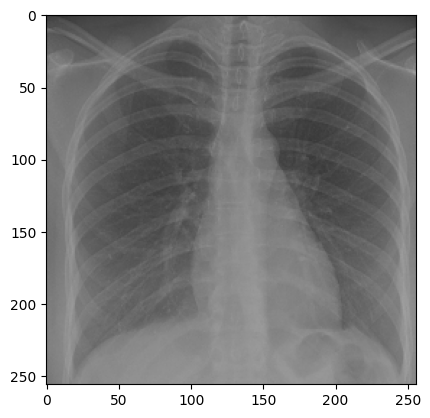

In [ ]:
np_image_data = np.array(image_data)
    #Get a black and white version of the image and create a segmentation
UNET_seg = preds[6]
    #Put the numpy image and the segmentation and create an ROI
ROI_image_data = create_apply_ROI(np_image_data, cv2.resize(UNET_seg, (1000,1000)))

    #Turn the ROI extracted image back into a PIL image
PIL_ROI_image_data = Image.fromarray(ROI_image_data)

plt.imshow(PIL_ROI_image_data)
plt.show()

In [ ]:
np.array(PIL_ROI_image_data).shape

(256, 256, 3)

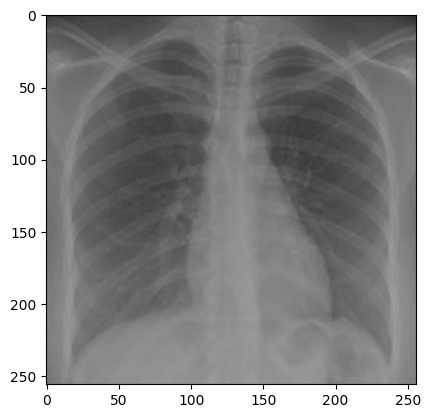

In [ ]:
np_image_data = np.array(image_data)
    #Get a black and white version of the image and create a segmentation
UNET_seg = preds[6]
    #Put the numpy image and the segmentation and create an ROI
ROI_image_data = create_apply_ROI(cv2.resize(np_image_data, (224, 224)), UNET_seg)

    #Turn the ROI extracted image back into a PIL image
PIL_ROI_image_data = Image.fromarray(ROI_image_data)

plt.imshow(PIL_ROI_image_data)
plt.show()

In [ ]:
np.array(PIL_ROI_image_data)

array([[[ 51,  51,  51],
        [ 50,  50,  50],
        [ 50,  50,  50],
        ...,
        [ 47,  47,  47],
        [ 45,  45,  45],
        [ 43,  43,  43]],

       [[ 58,  58,  58],
        [ 57,  57,  57],
        [ 56,  56,  56],
        ...,
        [ 50,  50,  50],
        [ 48,  48,  48],
        [ 46,  46,  46]],

       [[ 65,  65,  65],
        [ 65,  65,  65],
        [ 64,  64,  64],
        ...,
        [ 53,  53,  53],
        [ 51,  51,  51],
        [ 50,  50,  50]],

       ...,

       [[116, 116, 116],
        [116, 116, 116],
        [118, 118, 118],
        ...,
        [127, 127, 127],
        [128, 128, 128],
        [128, 128, 128]],

       [[116, 116, 116],
        [117, 117, 117],
        [118, 118, 118],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [127, 127, 127]],

       [[117, 117, 117],
        [117, 117, 117],
        [118, 118, 118],
        ...,
        [130, 130, 130],
        [129, 129, 129],
        [127, 127, 127]]

In [ ]:
from __future__ import print_function
from __future__ import division
import os
import argparse
import distutils.util
import numpy as np
import sys
import torch
import torch.nn as nn
from torchvision import models, transforms
# from sklearn.metrics import roc_auc_score
# from PIL import Image
# import time

import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
import time
import copy
# from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import metrics

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch NIH-CXR Testing')

parser.add_argument('--arch', '-a', metavar='ARCH', default='densenet121')
parser.add_argument('--img_size', '-sz', default=256, type=int)
parser.add_argument('--crop_size', '-cs', default=224, type=int)
parser.add_argument('--epoch', '-ep', default=50, type=int)
parser.add_argument('--batch_size', '-bs', default=16, type=int)
parser.add_argument('--learning_rate', '-lr', default=0.001, type=float)
parser.add_argument('--gpu_id', '-gpu', default=0, type=int)
#parser.add_argument('--test_labels', default='att', type=str) #default: '': attending radiologist labels. 'con' for radiologist consensus.
parser.add_argument('-f')


def run_ROI_test():
	global args
	args = parser.parse_args()

	model = models.__dict__[args.arch](pretrained=True)

	torch.cuda.set_device(args.gpu_id)

	# number of classes
	numClass = 1

	# image folder location
	img_dir = "/content/drive/MyDrive/chest_x_ray_images_012/images"

	# dataset split files
	split_file_dir = './dataset_split'
	split_name = 'test'
	splits = [split_name]

	#if args.test_labels == 'att':
#		split_file_suffix = '_attending_rad.txt'
	#elif args.test_labels == 'con':
	#	split_file_suffix = '_rad_consensus_voted3.txt'
#
#	split_files = {}
#	for split in splits:
#		split_files[split] = os.path.join(split_file_dir,
#			split+split_file_suffix)



	# modify the last FC layer to number of classes
	num_ftrs = model.classifier.in_features
	model.classifier = nn.Linear(num_ftrs, numClass)

	model = model.cuda()

	model_path = '/content/drive/MyDrive/densenet121_256_64_0.001'

	model.load_state_dict(torch.load(model_path)['state_dict'])

	ROI_test(img_dir, '/content/drive/MyDrive/test_rad_consensus_voted3.txt', split_name, model, batch_size=args.batch_size, \
		img_size=args.img_size, crop_size=args.crop_size, gpu_id=args.gpu_id)


def ROI_test(img_dir, split_test, split_name, model, batch_size, img_size, crop_size, gpu_id):

	# -------------------- SETTINGS: CXR DATA TRANSFORMS -------------------
	normalizer = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
	data_transforms = {split_name: transforms.Compose([
		transforms.Resize(img_size),
		# transforms.RandomResizedCrop(crop_size),
		transforms.CenterCrop(crop_size),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])}

	# -------------------- SETTINGS: DATASET BUILDERS -------------------
	datasetTest = ROIDataGenerator(img_dir=img_dir, split_file=split_test,
								transform=data_transforms[split_name])

	dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=batch_size,
								shuffle=False, num_workers=2, pin_memory=True)

	dataloaders = {}
	dataloaders[split_name] = dataLoaderTest

	print('Number of testing CXR images: {}'.format(len(datasetTest)))
	dataset_sizes = {split_name: len(datasetTest)}

	# -------------------- TESTING -------------------
	model.eval()
	running_corrects = 0
	output_list = []
	label_list = []
	preds_list = []


	with torch.no_grad():
		# Iterate over data.
		for data in dataloaders[split_name]:
			inputs, labels, img_names = data

			labels_auc = labels
			labels_print = labels
			labels_auc = labels_auc.type(torch.FloatTensor)
			labels = labels.type(torch.LongTensor) #add for BCE loss

			# wrap them in Variable
			inputs = inputs.cuda(gpu_id, non_blocking=True)
			labels = labels.cuda(gpu_id, non_blocking=True)
			labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

			labels = labels.view(labels.size()[0],-1) #add for BCE loss
			labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
			# forward
			outputs = model(inputs)
			# _, preds = torch.max(outputs.data, 1)
			score = torch.sigmoid(outputs)
			score_np = score.data.cpu().numpy()
			preds = score>0.995
			preds_np = preds.data.cpu().numpy()
			preds = preds.type(torch.cuda.LongTensor)

			labels_auc = labels_auc.data.cpu().numpy()
			outputs = outputs.data.cpu().numpy()

			for j in range(len(img_names)):
				print(str(img_names[j]) + ': ' + str(score_np[j]) + ' GT: ' + str(labels_print[j]))

			for i in range(outputs.shape[0]):
				output_list.append(outputs[i].tolist())
				label_list.append(labels_auc[i].tolist())
				preds_list.append(preds_np[i].tolist())

			# running_corrects += torch.sum(preds == labels.data)
			# labels = labels.type(torch.cuda.FloatTensor)
			running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss

	acc = np.float(running_corrects) / dataset_sizes[split_name]
	auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
	# print(auc)
	fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
	roc_auc = metrics.auc(fpr, tpr)

	ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

	tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

	recall = tp/(tp+fn)
	precision = tp/(tp+fp)
	f1 = 2*precision*recall/(precision+recall)
	sensitivity = recall
	specificity = tn/(tn+fp)
	PPV = tp/(tp+fp)
	NPV = tn/(tn+fn)
	print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
	print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
	print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
	print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
	print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
	# Plot all ROC curves
	plt.figure()
	plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.0])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC curve of abnormal/normal classification: '+args.arch)
	plt.legend(loc="lower right")
	#plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
	plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of testing CXR images: 459
/content/drive/MyDrive/chest_x_ray_images_012/images/00030408_011.png: [0.9985227] GT: tensor(1)
/content/drive/MyDrive/chest_x_ray_images_012/images/00030791_000.png: [0.04274563] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029637_000.png: [0.6088708] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029811_000.png: [0.33296627] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00030110_000.png: [0.28752318] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029534_000.png: [0.23731095] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00028602_000.png: [0.2871563] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029733_000.png: [0.4089358] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00028404_000.png: [0.03007838] GT: tensor(0)
/content/drive/MyDrive/chest_x_ray_images_012/images/00029829_000.png: [0.52756405] GT: 

<ipython-input-56-faca219ab078>:132: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = np.float(running_corrects) / dataset_sizes[split_name]


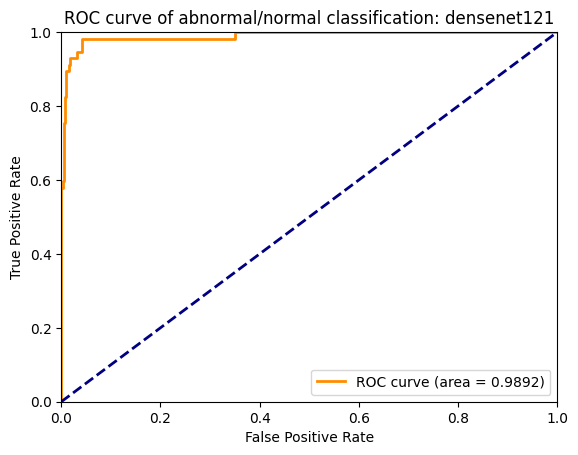

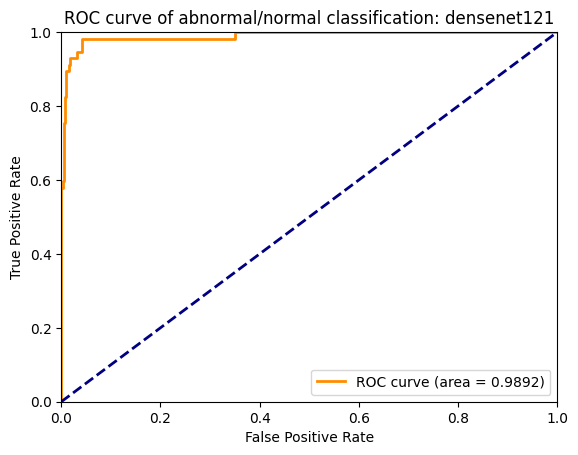

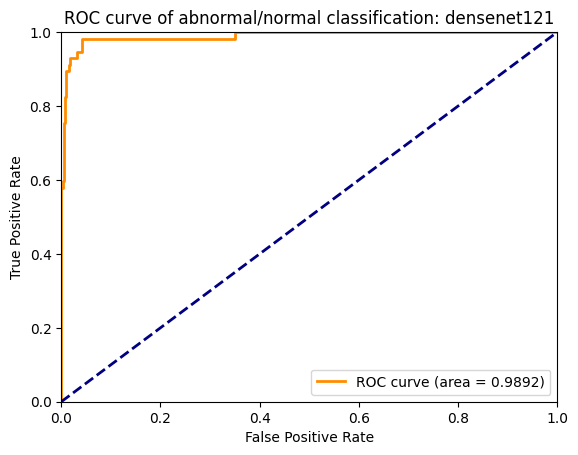

In [ ]:
run_ROI_test()

# Run Classification model on ROI extracted validation data

In [ ]:
tf_classification_model.evaluate(extractedROIs, y_val)

# Attempt to find similarity between images and take out bad images

In [ ]:
UNET_preds = UNETmodel.predict(X_val_1)
loss, acc, extra = UNETmodel.evaluate(X_val_1, y_val)

In [ ]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [ ]:
def create_bad_image_CNN_data():
  initial_accuracy_list = []
  for x in range(len(UNET_preds)):
    accuracy = DICE_COE(prediction_ROI_list[x], ground_truth_ROI_list[x])
    initial_accuracy_list.append([accuracy,x])


  return initial_accuracy_list